In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys
import pandas as pd

from importlib import reload

# Init Fidle environment
import fidle

run_id, run_dir, datasets_dir = fidle.init('GTSRB2bis')

2023-06-28 14:58:01.246167: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 14:58:01.273106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 14:58:01.798250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : GTSRB2bis
Run dir              : ./run/GTSRB2bis
Datasets dir         : /home/hcourtei/Projects/FormationSED/PreProcess_29Juin2023/image_preproc/preprocessing_visualization/image/datasets-fidle
Start time           : 28/06/23 14:58:02
Hostname             : ptb-jkp7wl3.irisa.fr (Linux)
Tensorflow log level : Warning + Error  (=1)
Update keras cache   : False
Save figs            : ./run/GTSRB2bis/figs (False)
tensorflow           : 2.12.0
tensorflow.keras     : 2.12.0
numpy                : 1.23.5
sklearn              : 1.2.2
matplotlib           : 3.7.1
pandas               : 2.0.2


In [2]:
# enhanced_dir = './data'
enhanced_dir = datasets_dir +'/data_GTSRB_enhanced' 

# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 15
scale         = 1
fit_verbosity = 1
fidle.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale', 'fit_verbosity')

In [3]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    chrono=fidle.Chrono()
    chrono.start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    # print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=fidle.utils.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = chrono.get_delay()
    size     = fidle.utils.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

print(x_train.shape)
# ---- Rescale 
#
# x_train,y_train, x_test,y_test = fidle.utils.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

Datasets have been shuffled.
Dataset "set-24x24-L" is loaded and shuffled. (23.4 Mo in 0:00:00)
(3920, 24, 24, 1)


In [4]:
def get_model(input_shape):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=input_shape))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
   # model.add( keras.layers.Dense(500, activation='relu'))
   # model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

In [5]:
model_name = 'Baseline'
import time
size = 24 # 48
all_results = {}
idx = 0 
for size in [24,48]:
    for mode in ['RGB', 'RGB-HE', 'L', 'L-LHE']: # , 'L', 'L-LHE']:
        start = time.time()
        dataset_name = f'set-{size}x{size}-{mode}'
        # ---- Callback ModelCheckpoint - Save best model
        exp_dir = run_dir + f"/{model_name}_{dataset_name}"
        all_results[f'{model_name}_{dataset_name}'] ={}
        bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=exp_dir+'/best.model.h5', verbose=0, monitor='accuracy', save_best_only=True)
        # ---- Callback tensorboard
        log_dir = exp_dir + "/logs/tb_" + fidle.Chrono.tag_now()
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)
        input_shape = x_train.shape[1:]
        print(f"Training n° {idx} with model {model_name} on dataset {dataset_name} with input shape {input_shape}")

        model = get_model(input_shape)
        model.compile(optimizer = 'adam', loss      = 'sparse_categorical_crossentropy', metrics   = ['accuracy'])
        
        history = model.fit( x_train, y_train,
                            batch_size      = batch_size,
                            epochs          = epochs,
                            verbose         = 0,
                            validation_data = (x_test, y_test),
                            callbacks=[tensorboard_callback, bestmodel_callback])
        
        training_time = round(time.time() - start)
        print(f"End Training n° {idx} with model {model_name} on dataset {dataset_name} in {training_time} s ... Testing best model")

        loaded_model = tf.keras.models.load_model(exp_dir+'/best.model.h5')
        score = loaded_model.evaluate(x_test, y_test, verbose=0)
        df = pd.DataFrame.from_dict(history.history,orient='index').transpose()

        all_results[f'{model_name}_{dataset_name}']['df_metrics'] = df
        all_results[f'{model_name}_{dataset_name}']['df_metrics'] = df
        all_results[f'{model_name}_{dataset_name}']['nb_params'] = model.count_params()
        all_results[f'{model_name}_{dataset_name}']['test_loss'] = score[0]
        all_results[f'{model_name}_{dataset_name}']['test_accuracy'] = score[1]
        all_results[f'{model_name}_{dataset_name}']['training_time'] = training_time

        idx += 1






Datasets have been shuffled.
Dataset "set-24x24-RGB" is loaded and shuffled. (68.9 Mo in 0:00:00)
Training n° 0 with model Baseline on dataset set-24x24-RGB with input shape (24, 24, 3)


2023-06-28 14:58:07.790209: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


End Training n° 0 with model Baseline on dataset set-24x24-RGB in 60 s ... Testing best model
Datasets have been shuffled.
Dataset "set-24x24-RGB-HE" is loaded and shuffled. (68.9 Mo in 0:00:00)
Training n° 1 with model Baseline on dataset set-24x24-RGB-HE with input shape (24, 24, 3)
End Training n° 1 with model Baseline on dataset set-24x24-RGB-HE in 47 s ... Testing best model
Datasets have been shuffled.
Dataset "set-24x24-L" is loaded and shuffled. (23.4 Mo in 0:00:00)
Training n° 2 with model Baseline on dataset set-24x24-L with input shape (24, 24, 1)
End Training n° 2 with model Baseline on dataset set-24x24-L in 44 s ... Testing best model
Datasets have been shuffled.
Dataset "set-24x24-L-LHE" is loaded and shuffled. (23.4 Mo in 0:00:00)
Training n° 3 with model Baseline on dataset set-24x24-L-LHE with input shape (24, 24, 1)
End Training n° 3 with model Baseline on dataset set-24x24-L-LHE in 57 s ... Testing best model
Datasets have been shuffled.
Dataset "set-48x48-RGB" is l

In [6]:
print(f'To run tensorboard :\ntensorboard --logdir {run_dir}')
all_results


To run tensorboard :
tensorboard --logdir ./run/GTSRB2bis


{'Baseline_set-24x24-RGB': {'df_metrics':         loss  accuracy  val_loss  val_accuracy
  0   3.361322  0.123469  2.961531      0.228029
  1   2.370034  0.369898  1.982654      0.463183
  2   1.521536  0.576020  1.390695      0.612827
  3   0.992225  0.711224  1.038224      0.729216
  4   0.680973  0.814796  0.922669      0.764054
  5   0.518247  0.854847  0.804852      0.801267
  6   0.405540  0.886225  0.742933      0.808393
  7   0.324437  0.912500  0.710488      0.842439
  8   0.277516  0.925000  0.682605      0.845606
  9   0.224394  0.940306  0.651082      0.840063
  10  0.194253  0.949745  0.623509      0.866983
  11  0.161333  0.957908  0.665138      0.861441
  12  0.156610  0.957398  0.649277      0.873317
  13  0.153788  0.955102  0.643649      0.862233
  14  0.119453  0.966327  0.659880      0.874109,
  'nb_params': 300907,
  'test_loss': 0.6598794460296631,
  'test_accuracy': 0.8741092681884766,
  'training_time': 60},
 'Baseline_set-24x24-RGB-HE': {'df_metrics':         l

Text(0.5, 1.0, 'Validation accuracy')

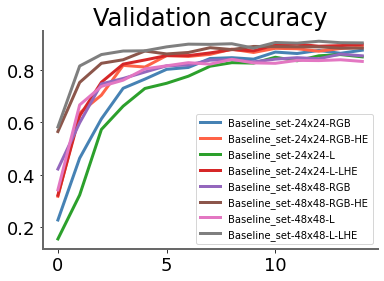

In [7]:
# TO do plot learning cur
plt.figure()
for exp in all_results:  # pd Dataframe .filter(regex=("val."))
    all_results[exp]['df_metrics']["val_accuracy"].plot(legend=False)
    
plt.legend(list(all_results.keys()))
plt.title("Validation accuracy")

Datasets have been shuffled.
Dataset "set-24x24-RGB" is loaded and shuffled. (68.9 Mo in 0:00:00)
40/40 [==============================] - 1s 16ms/step


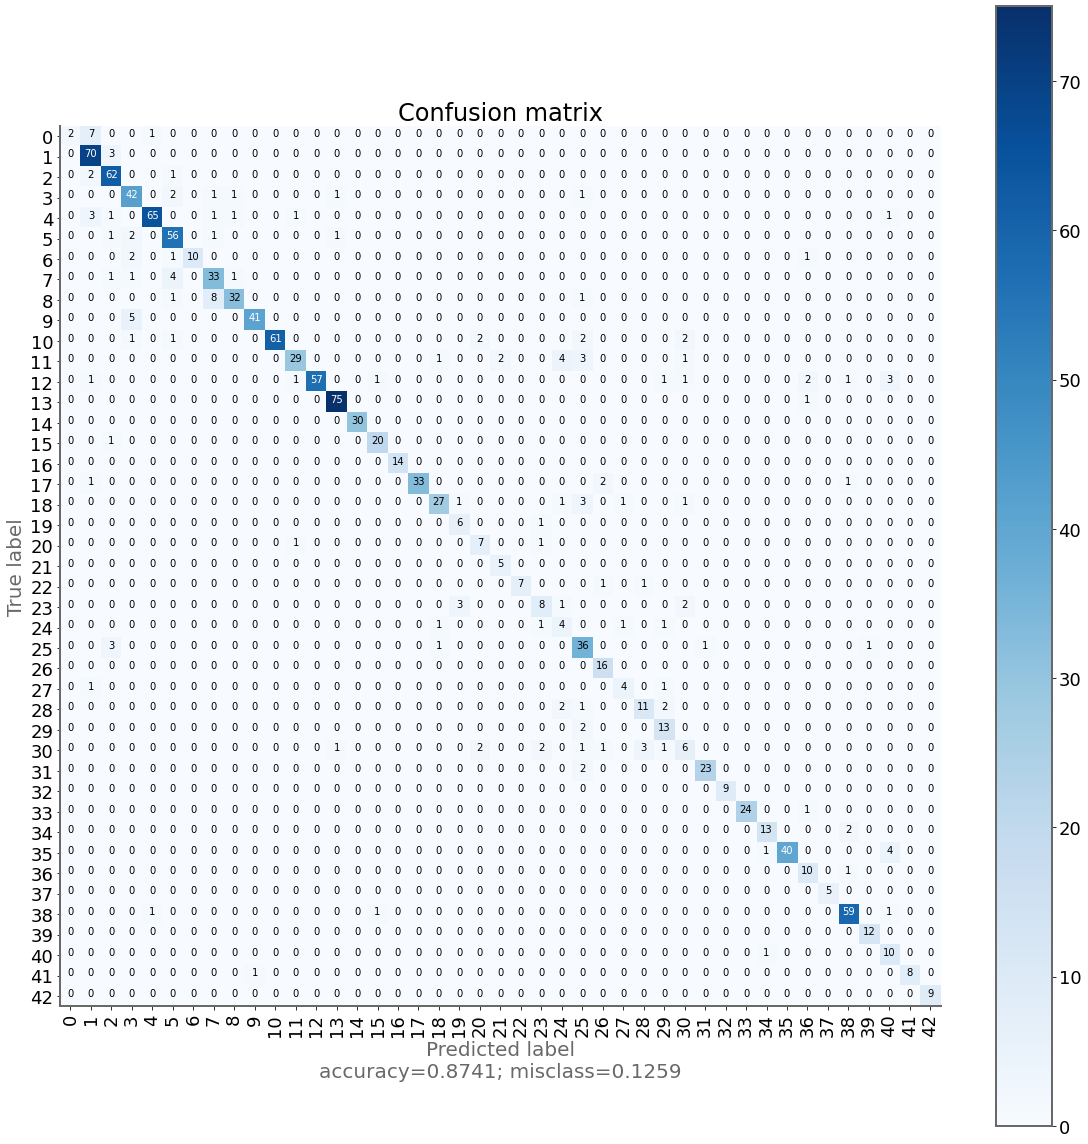

Datasets have been shuffled.
Dataset "set-24x24-RGB-HE" is loaded and shuffled. (68.9 Mo in 0:00:00)
40/40 [==============================] - 1s 14ms/step


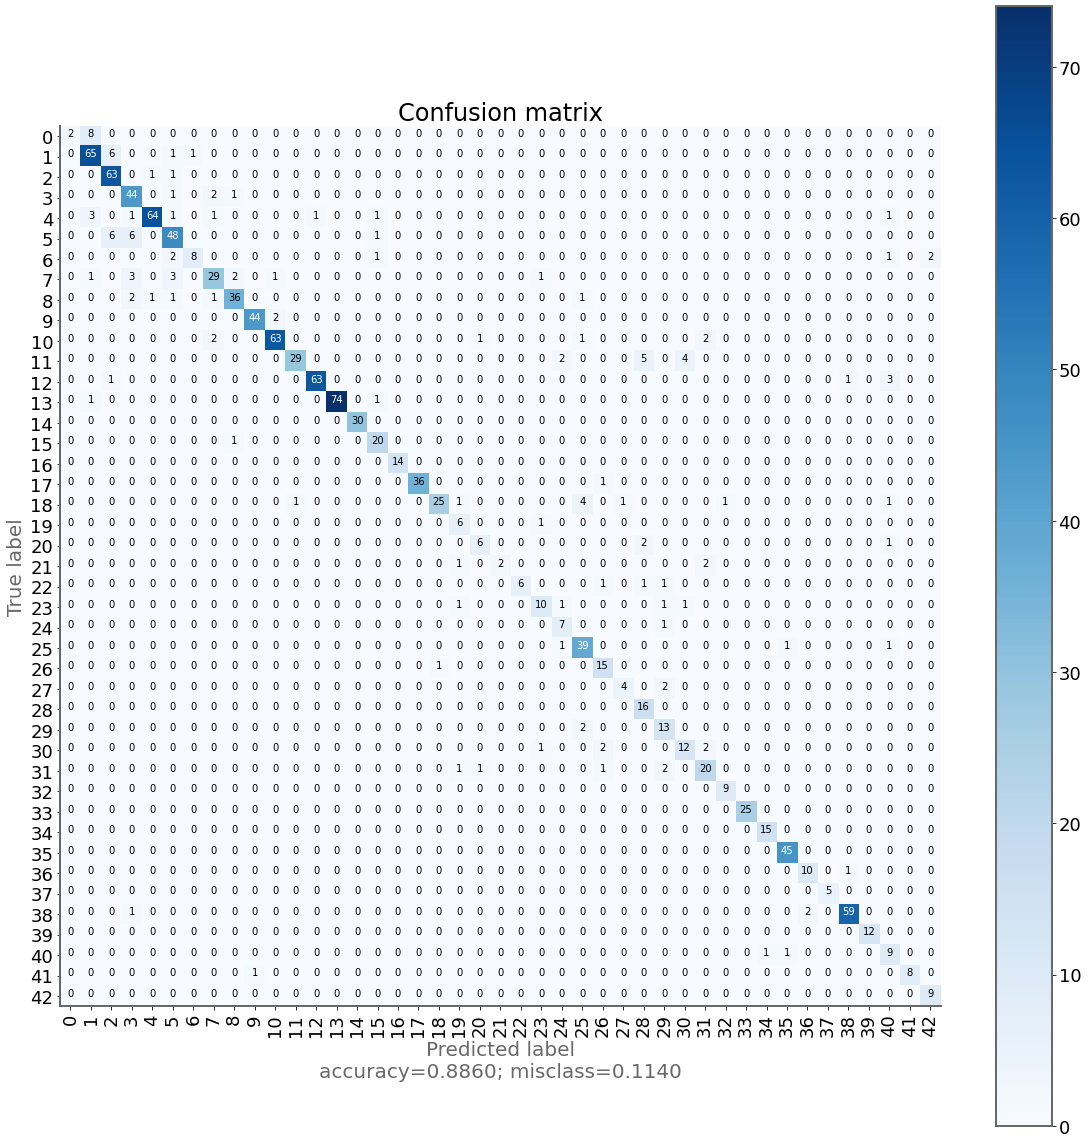

Datasets have been shuffled.
Dataset "set-24x24-L" is loaded and shuffled. (23.4 Mo in 0:00:00)
40/40 [==============================] - 0s 5ms/step


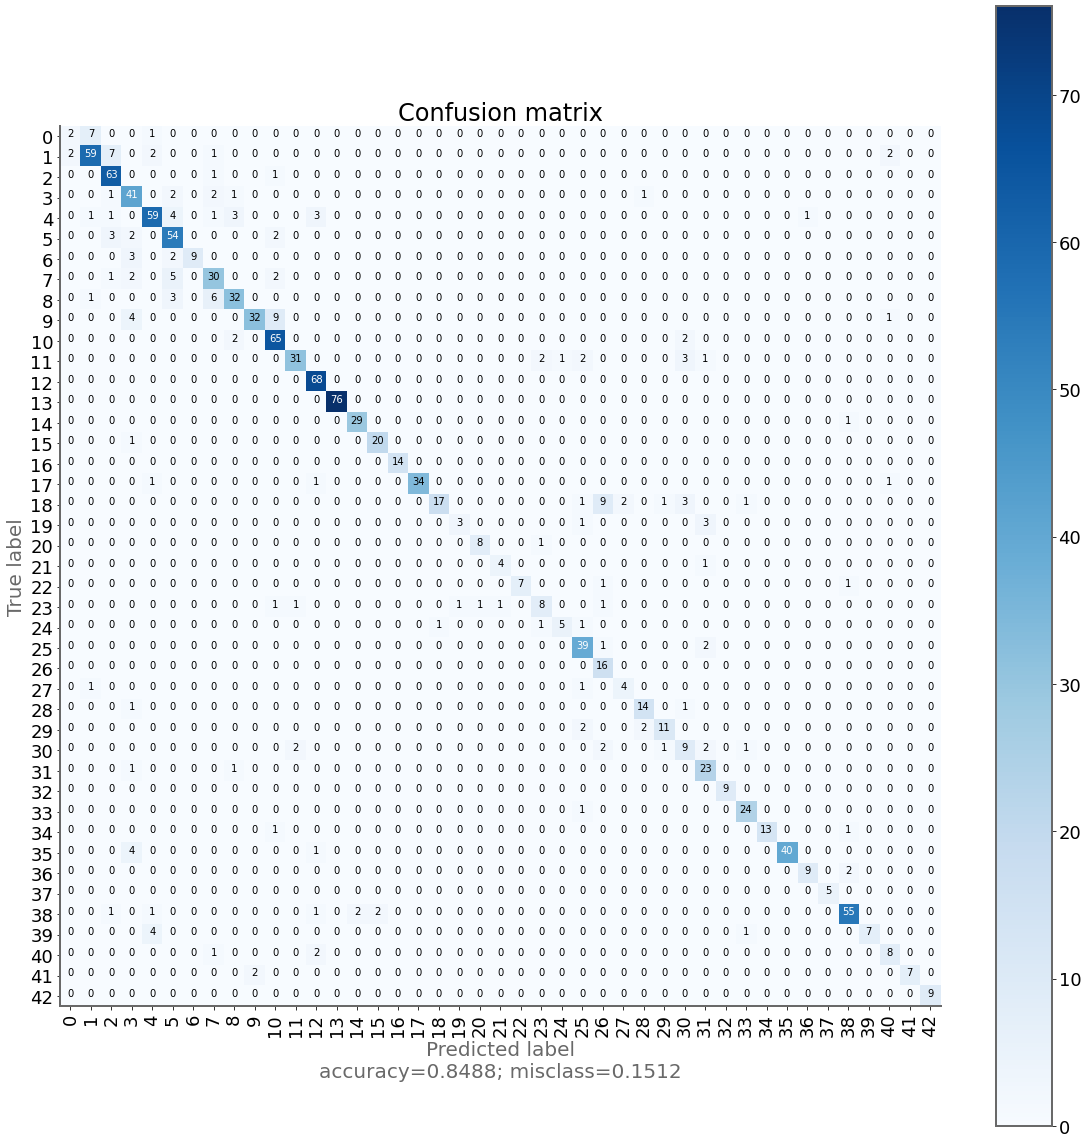

Datasets have been shuffled.
Dataset "set-24x24-L-LHE" is loaded and shuffled. (23.4 Mo in 0:00:00)
40/40 [==============================] - 1s 15ms/step


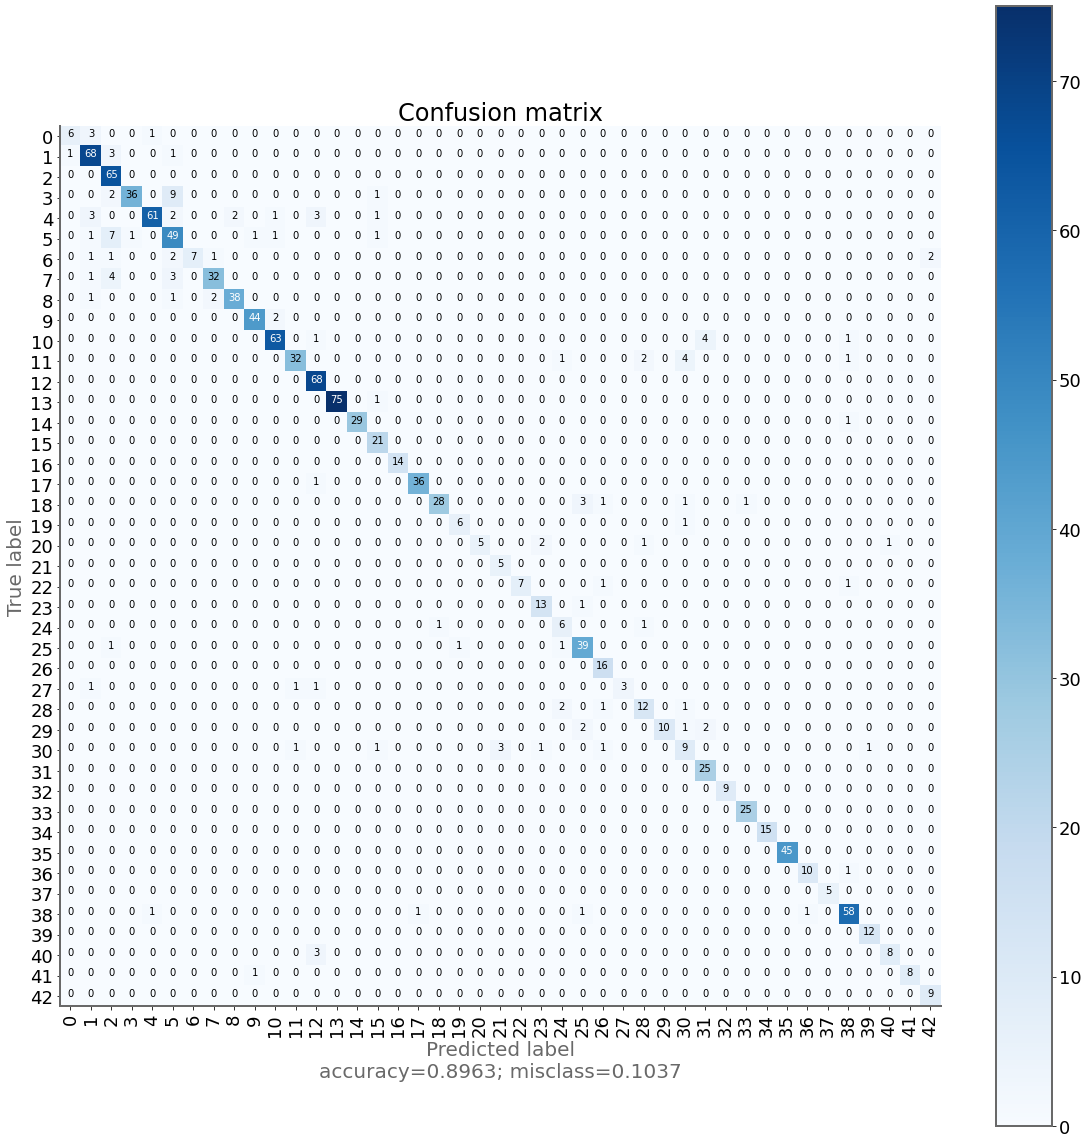

Datasets have been shuffled.
Dataset "set-48x48-RGB" is loaded and shuffled. (275.6 Mo in 0:00:00)
40/40 [==============================] - 2s 41ms/step


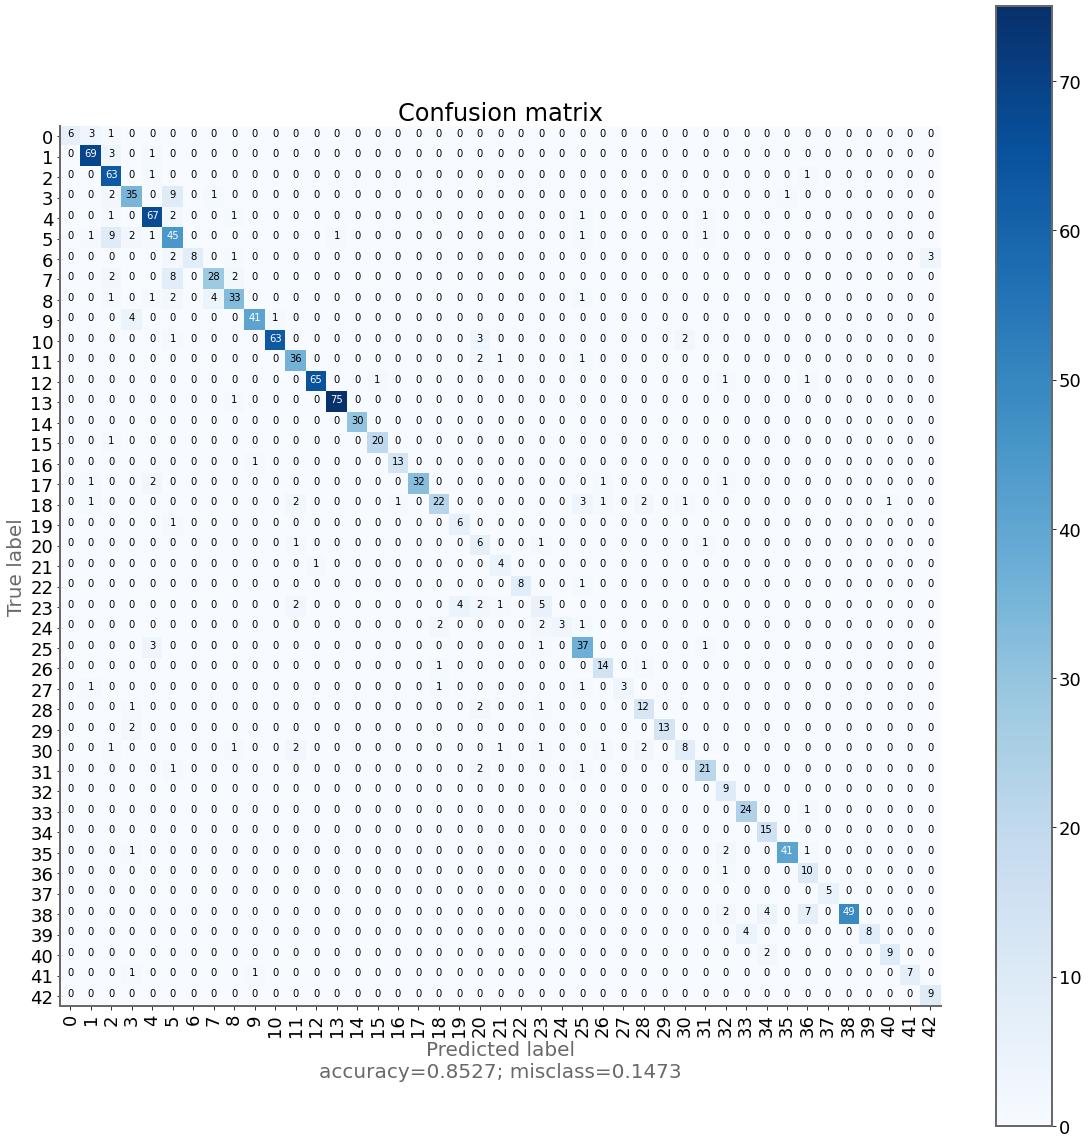

Datasets have been shuffled.
Dataset "set-48x48-RGB-HE" is loaded and shuffled. (275.6 Mo in 0:00:00)
40/40 [==============================] - 2s 42ms/step


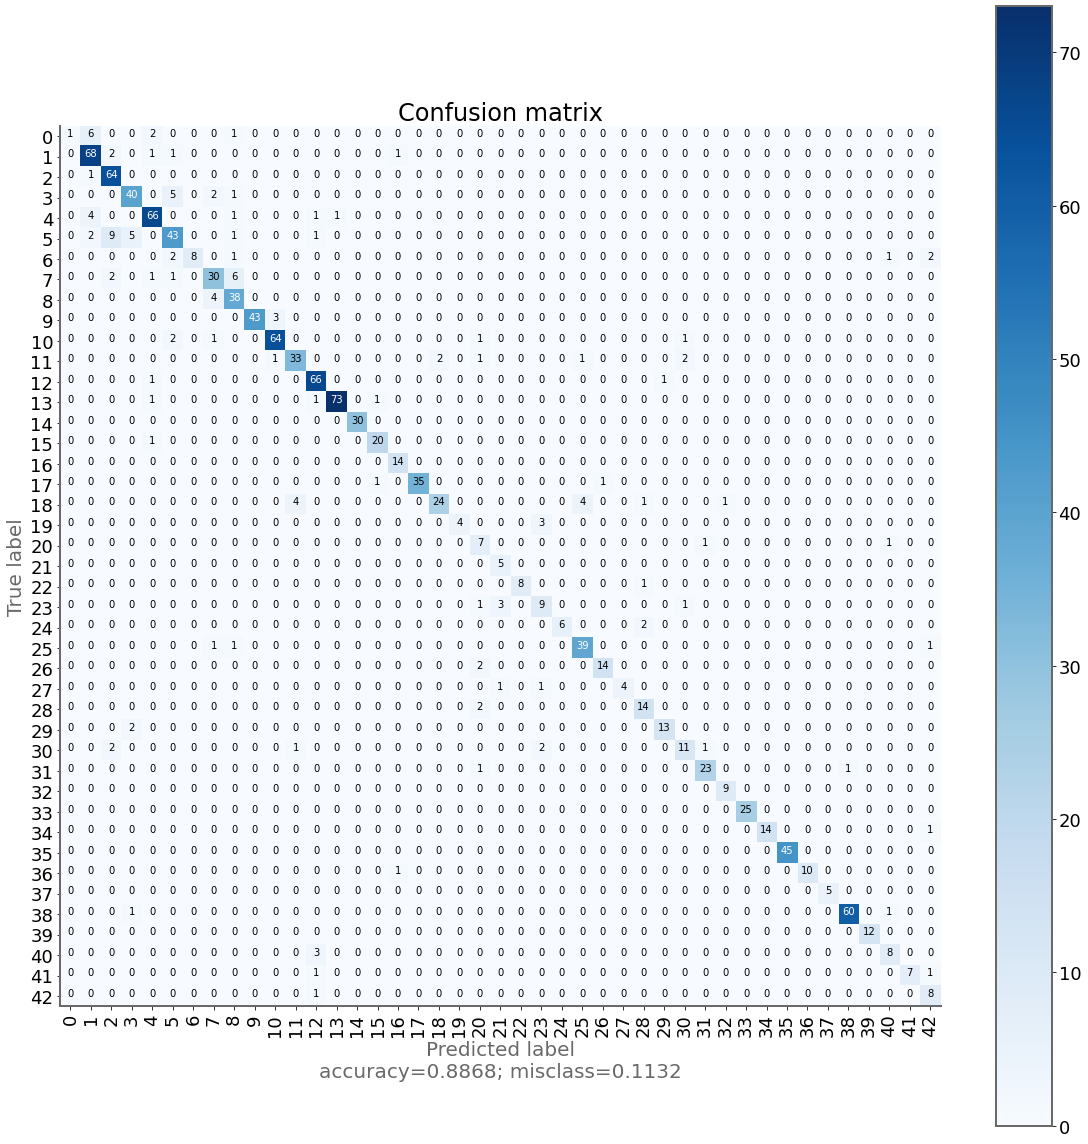

Datasets have been shuffled.
Dataset "set-48x48-L" is loaded and shuffled. (93.4 Mo in 0:00:00)
40/40 [==============================] - 2s 39ms/step


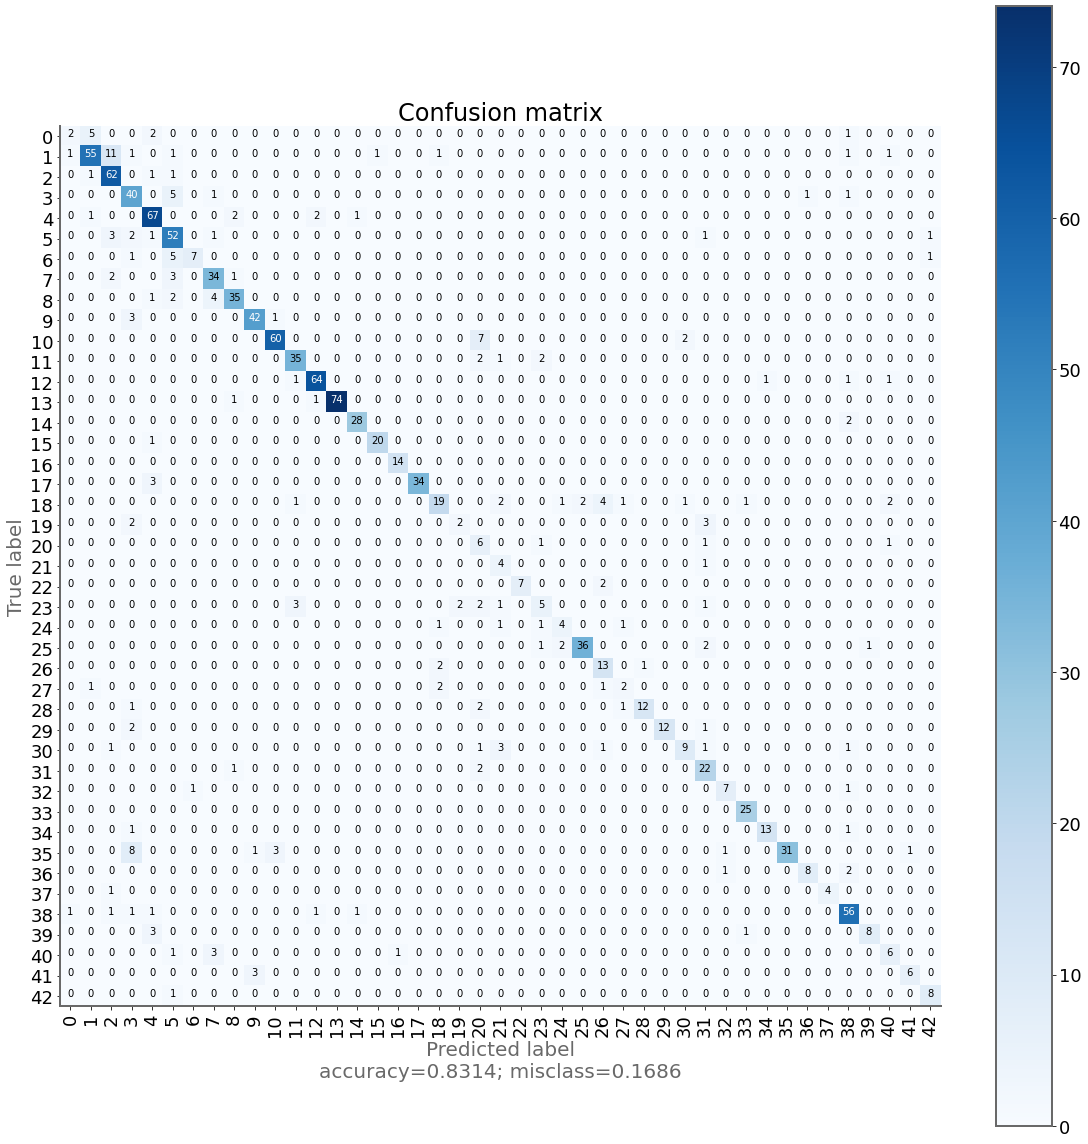

Datasets have been shuffled.
Dataset "set-48x48-L-LHE" is loaded and shuffled. (93.4 Mo in 0:00:00)
40/40 [==============================] - 2s 36ms/step


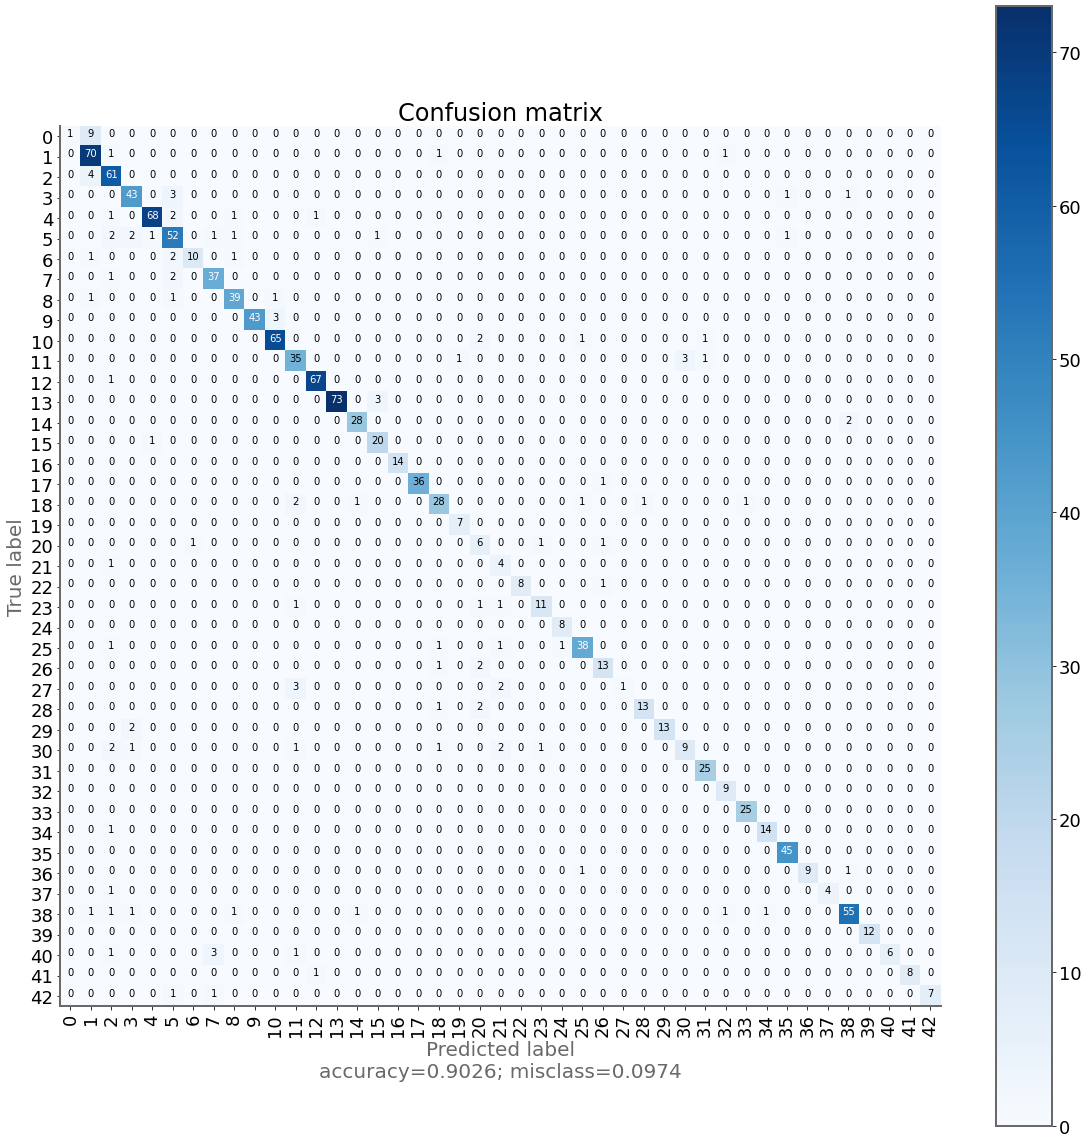

In [8]:
# ------PREDICTION ------------------------------
model_name = 'Baseline'
idx = 0 
for size in [24,48]:
    for mode in ['RGB', 'RGB-HE', 'L', 'L-LHE']: # , 'L', 'L-LHE']:
        dataset_name = f'set-{size}x{size}-{mode}'
        # ---- Callback ModelCheckpoint - Save best model
        save_dir = run_dir + f"/{model_name}_{dataset_name}"
        x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)
    
        loaded_model = tf.keras.models.load_model(save_dir+'/best.model.h5')
        score = loaded_model.evaluate(x_test, y_test, verbose=0)
        all_results[f'{model_name}_{dataset_name}']['test_loss'] = score[0]
        all_results[f'{model_name}_{dataset_name}']['test_accuracy'] = score[1]
        y_sigmoid = loaded_model.predict(x_test)
        y_pred    = np.argmax(y_sigmoid, axis=-1)
        fidle.scrawler.confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, save_as='04-confusion-matrix')
        idx += 1 
    

In [9]:
best_val_acc_df = pd.DataFrame(columns=['experiments', 'training_time',  'best_val_accuracy'])
for idx , exp in enumerate(all_results):
    # print(f" Exp : {exp} best val accuracy {round(all_results[exp]['test_accuracy'],2)}")
    best_val_acc_df.loc[idx] = [exp, all_results[exp]['training_time'], round(all_results[exp]['test_accuracy'],2)]

best_val_acc_df

experiments  training_time  best_val_accuracy
0     Baseline_set-24x24-RGB             60               0.87
1  Baseline_set-24x24-RGB-HE             47               0.89
2       Baseline_set-24x24-L             44               0.85
3   Baseline_set-24x24-L-LHE             57               0.90
4     Baseline_set-48x48-RGB            104               0.85
5  Baseline_set-48x48-RGB-HE            109               0.89
6       Baseline_set-48x48-L            107               0.83
7   Baseline_set-48x48-L-LHE            105               0.90